In [1]:
%run ../../common_utils.py

In [2]:
from catboost import CatBoostRegressor
import optuna
from optuna.samplers import TPESampler
from IPython.utils import io
import unidecode
from catboost import Pool

In [3]:
random_state = 1
number_of_splits = 5

In [5]:
def load_data(val_data=False,path=None,cat_unknown=False):
    train, test, metadata = load_all_data(path=path)
    nonCategorical, categorical = get_cat_and_non_cat_data(metadata)
    all_features = list(train.columns)
    all_features.remove('price')
    numerical_features = ['area_total','area_kitchen','area_living','floor','rooms','ceiling',
        'bathrooms_shared','bathrooms_private','balconies','loggias','phones','building_id','constructed','stories']
    categorical_to_numerical(train, ['street','address'])
    categorical_to_numerical(test, ['street','address'])
    if not val_data:
        X_train, y_train, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                            outliers_value=7, val_data=val_data, val_split=0.2, random_state=42, scaler="std",
                            add_R="True", add_rel_height="True", droptable=[],
                            one_hot_encode=False, cat_features=categorical, drop_old=True,categorical_unknown=cat_unknown)
        y_train_log = np.log(y_train)
        return X_train, y_train, y_train_log, test_labels
    else:
        X_train, y_train, X_test, y_test, test_labels = pre_process_numerical(features = all_features, numerical_features = numerical_features, train = train, test = test,
                            outliers_value=7, val_data=val_data, val_split=0.2, random_state=42, scaler="std",
                            add_R="True", add_rel_height="True", droptable=[],
                            one_hot_encode=False, cat_features=categorical, drop_old=True,categorical_unkown=cat_unknown)
        y_train_log = np.log(y_train)
        return X_train, y_train, y_train_log, X_test, y_test, test_labels

In [22]:
%%capture --no-display
X_train, y_train, y_train_log, test_labels = load_data(path='../',cat_unknown=True)
test_pd = test_labels.copy()
selected_features_catboost=['building_id','area_kitchen', 'area_living',
       'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private',
       'windows_court', 'windows_street', 'balconies', 'loggias', 'phones',
       'new', 'street', 'address', 'seller', 'layout', 'condition', 'district',
       'constructed', 'stories', 'elevator_without', 'elevator_passenger',
       'material', 'parking', 'heating', 'r', 'rel_height']

X_train = X_train[selected_features_catboost]
test_labels = test_labels[selected_features_catboost]
_, _, metadata = load_all_data(path='../')
_, categorical = get_cat_and_non_cat_data(metadata)
text_features=['street','address']
categorical.append('street')
categorical.append('address')
X_train = X_train.astype({'street':'int','address':'int','seller':'int','layout':'int','condition':'int','district':'int','material':'int','parking':'int','heating':'int'})
test_labels = test_labels.astype({'street':'int','address':'int','seller':'int','layout':'int','condition':'int','district':'int','material':'int','parking':'int','heating':'int'})

In [66]:
model1 = CatBoostRegressor(random_state=random_state,loss_function='RMSE', cat_features=categorical)

scores, average_score, best_model, best_index = catboost_groupKFold(number_of_splits, model1, X_train, y_train_log, categorical_features=[],text_features=[],random_state=random_state)

starting on split  1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


starting on split  2
starting on split  3
starting on split  4
starting on split  5


In [67]:
print("average score: ", average_score)

average score:  ([0.26136777437555175, 0.2606464150806193, 0.2462335758331197, 0.2632073672101002, 0.291418239654299], 0.26457467443073795, <catboost.core.CatBoostRegressor object at 0x00000174C73E3D60>, 4)


In [68]:
model2 = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    thread_count=-1,
    depth=5,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)
scores, average_score, best_model, best_index = catboost_groupKFold(number_of_splits, model2, X_train, y_train_log, categorical_features=categorical,random_state=random_state)

starting on split  1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


starting on split  2
starting on split  3
starting on split  4
starting on split  5


In [69]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.28045662058144244, 0.2690561733445533, 0.24775573025631806, 0.2745180743432667, 0.32925386683584346]
average score:  0.28020809307228484
best model:     <catboost.core.CatBoostRegressor object at 0x00000174C75CD460>
best index:     4


In [7]:
best_params = {
    'learning_rate': 0.0772446776104594, 
    'l2_leaf_reg': 0.5709519938247928, 
    'colsample_bylevel': 0.09221911838854839, 
    'depth': 9, 
    'boosting_type': 'Plain', 
    'bootstrap_type': 'MVS', 
    'min_data_in_leaf': 17, 
    'one_hot_max_size': 11}
model = CatBoostRegressor(**best_params, random_state=random_state,loss_function='RMSE', cat_features=categorical)

In [10]:
model.fit(X_train,y_train_log,verbose=False)

In [26]:
predict_and_store(model, test_labels, test_pd, path="..\.\submissions\CB4.0.csv", exponential=True)

# Lot of extra features

In [11]:
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute", # Bool
                     "street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

# Load data
train, test, metaData = load_all_data(path='../')
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features, log_targets=False, log_area=True, fillNan=True)
# Add new features
train_labels, test_labels, added_features = feature_engineering(
    train_labels, 
    test_labels,
    add_base_features=True, 
    add_bool_features=True,
    add_weak_features=True,
    add_dist_to_metro=True,
    add_close_to_uni=True,
    add_dist_to_hospital=True,
    add_floor_features=True,
    add_street_info=True,
    )

# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")
# No One-hot encoding
    	# train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)
# Drop some features
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

droptable = ['street','address']
train_labels.drop(droptable, inplace=True, axis=1)
test_labels.drop(droptable, inplace=True, axis=1)

minMax


In [12]:
best_params = {
    'learning_rate': 0.0772446776104594, 
    'l2_leaf_reg': 0.5709519938247928, 
    'colsample_bylevel': 0.09221911838854839, 
    'depth': 9, 
    'boosting_type': 'Plain', 
    'bootstrap_type': 'MVS', 
    'min_data_in_leaf': 17, 
    'one_hot_max_size': 11}
model = CatBoostRegressor(**best_params, random_state=random_state,loss_function='RMSE', cat_features=cat_features)

In [17]:
cat_dict = {}
for feature in cat_features:
    cat_dict[feature] = 'int'

In [23]:
train_labels = train_labels.astype(cat_dict)
test_labels = test_labels.astype(cat_dict)

In [19]:
scores, average_score, best_model, best_index = catboost_groupKFold(
    number_of_splits=number_of_splits,
    model=model, 
    X_train=train_labels,
    y_train=np.log(train_targets),
    categorical_features=cat_features,
    random_state=random_state)

starting on split  1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


starting on split  2
starting on split  3
starting on split  4
starting on split  5


In [20]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.1991204515884232, 0.18186552619956745, 0.19983557876288044, 0.18737034071889158, 0.2504049982240116]
average score:  0.20371937909875487
best model:     <catboost.core.CatBoostRegressor object at 0x000002241E7F4550>
best index:     3


In [29]:
model.fit(train_labels,np.log(train_targets))
predict_and_store(model, test_labels, test, path="..\.\submissions\CB5.0.csv", exponential=True)

## Predict price per square meter

In [26]:
price_per_square_meter = train_targets/train['area_total']

In [28]:
scores, average_score, best_model, best_index = catboost_groupKFold(
    number_of_splits=number_of_splits,
    model=model, 
    X_train=train_labels.drop(['area_total'],axis=1),
    y_train=np.log(price_per_square_meter),
    categorical_features=cat_features,
    random_state=random_state)

starting on split  1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


starting on split  2
starting on split  3
starting on split  4
starting on split  5


In [30]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.1957361325499033, 0.1747421517448537, 0.1913325025733115, 0.1821555136129951, 0.23160374207763637]
average score:  0.19511400851174
best model:     <catboost.core.CatBoostRegressor object at 0x000002241E7F4550>
best index:     3


In [58]:
model.fit(train_labels.drop(['area_total'],axis=1),np.log(price_per_square_meter))
predict_and_store(model, test_labels.drop(['area_total'],axis=1), test, path="..\.\submissions\CB5.1.csv", exponential=True, price_per_sq = True, total_area_df = test['area_total'])

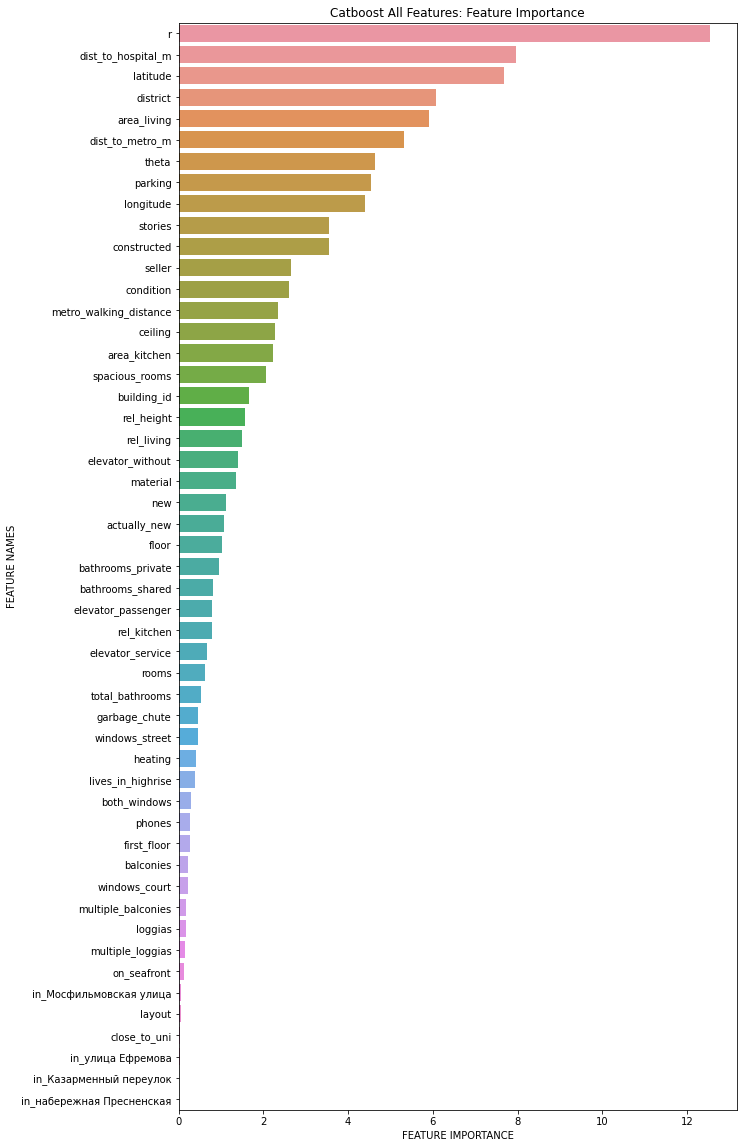

In [34]:
catboost_importances = model.feature_importances_
plot_feature_importance(catboost_importances, list(train_labels.drop(['area_total'],axis=1).columns), 'Catboost All Features: ')

## On 43 selected features

In [61]:
selected_features=[]
for i in range(0,len(catboost_importances)):
    if catboost_importances[i] > 0.15:
        features = (train_labels.columns)
        selected_features += [features[i]]

if 'building_id' not in selected_features:
    selected_features_building_id = selected_features + ['building_id']
else:
    selected_features_building_id = selected_features
    
train_labels_selected = train_labels[selected_features_building_id]
test_labels_selected = test_labels[selected_features_building_id]

In [50]:
print(len(selected_features))
print(len(train_labels.columns))

43
52


In [51]:
scores, average_score, best_model, best_index = catboost_groupKFold(
    number_of_splits=number_of_splits,
    model=model, 
    X_train=train_labels_selected.drop(['area_total'],axis=1),
    y_train=np.log(price_per_square_meter),
    categorical_features=cat_features,
    random_state=random_state)

starting on split  1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


starting on split  2
starting on split  3
starting on split  4
starting on split  5


In [52]:
print("scores:        ", scores)
print("average score: ", average_score)
print("best model:    ", best_model)
print("best index:    ", best_index)

scores:         [0.1943193920391938, 0.17255700230937596, 0.19767506495753484, 0.18440707022457256, 0.22548293950857212]
average score:  0.19488829380784986
best model:     <catboost.core.CatBoostRegressor object at 0x000002241E7F4550>
best index:     3


In [63]:
model.fit(train_labels_selected.drop(['area_total'],axis=1),np.log(price_per_square_meter))
predict_and_store(model, test_labels_selected.drop(['area_total'],axis=1), test, path="..\.\submissions\CB5.2.csv", exponential=True, price_per_sq = True, total_area_df = test['area_total'])

## On even less features (keep only 32)

In [70]:
selected_features=[]
for i in range(0,len(catboost_importances)):
    if catboost_importances[i] > 0.5:
        features = (train_labels.columns)
        selected_features += [features[i]]

if 'building_id' not in selected_features:
    selected_features_building_id = selected_features + ['building_id']
else:
    selected_features_building_id = selected_features
    
train_labels_selected = train_labels[selected_features_building_id]
test_labels_selected = test_labels[selected_features_building_id]
cat_features_selected = ['layout', 'condition', 'district', 'material', 'heating']

In [84]:
len(selected_features)

32

In [79]:
best_params = {
    'learning_rate': 0.0772446776104594, 
    'l2_leaf_reg': 0.5709519938247928, 
    'colsample_bylevel': 0.09221911838854839, 
    'depth': 9, 
    'boosting_type': 'Plain', 
    'bootstrap_type': 'MVS', 
    'min_data_in_leaf': 17, 
    'one_hot_max_size': 11}
model_selected = CatBoostRegressor(**best_params, random_state=random_state,loss_function='RMSE', cat_features=cat_features_selected)

In [81]:
scores, average_score, best_model, best_index = catboost_groupKFold(
    number_of_splits=number_of_splits,
    model=model_selected, 
    X_train=train_labels_selected.drop(['area_total'],axis=1),
    y_train=np.log(price_per_square_meter),
    categorical_features=cat_features_selected,
    random_state=random_state)

starting on split  1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


starting on split  2
starting on split  3
starting on split  4
starting on split  5


In [85]:
model_selected.fit(train_labels_selected.drop(['area_total'],axis=1),np.log(price_per_square_meter))
predict_and_store(model_selected, test_labels_selected.drop(['area_total'],axis=1), test, path="..\.\submissions\CB5.3.csv", exponential=True, price_per_sq = True, total_area_df = test['area_total'])